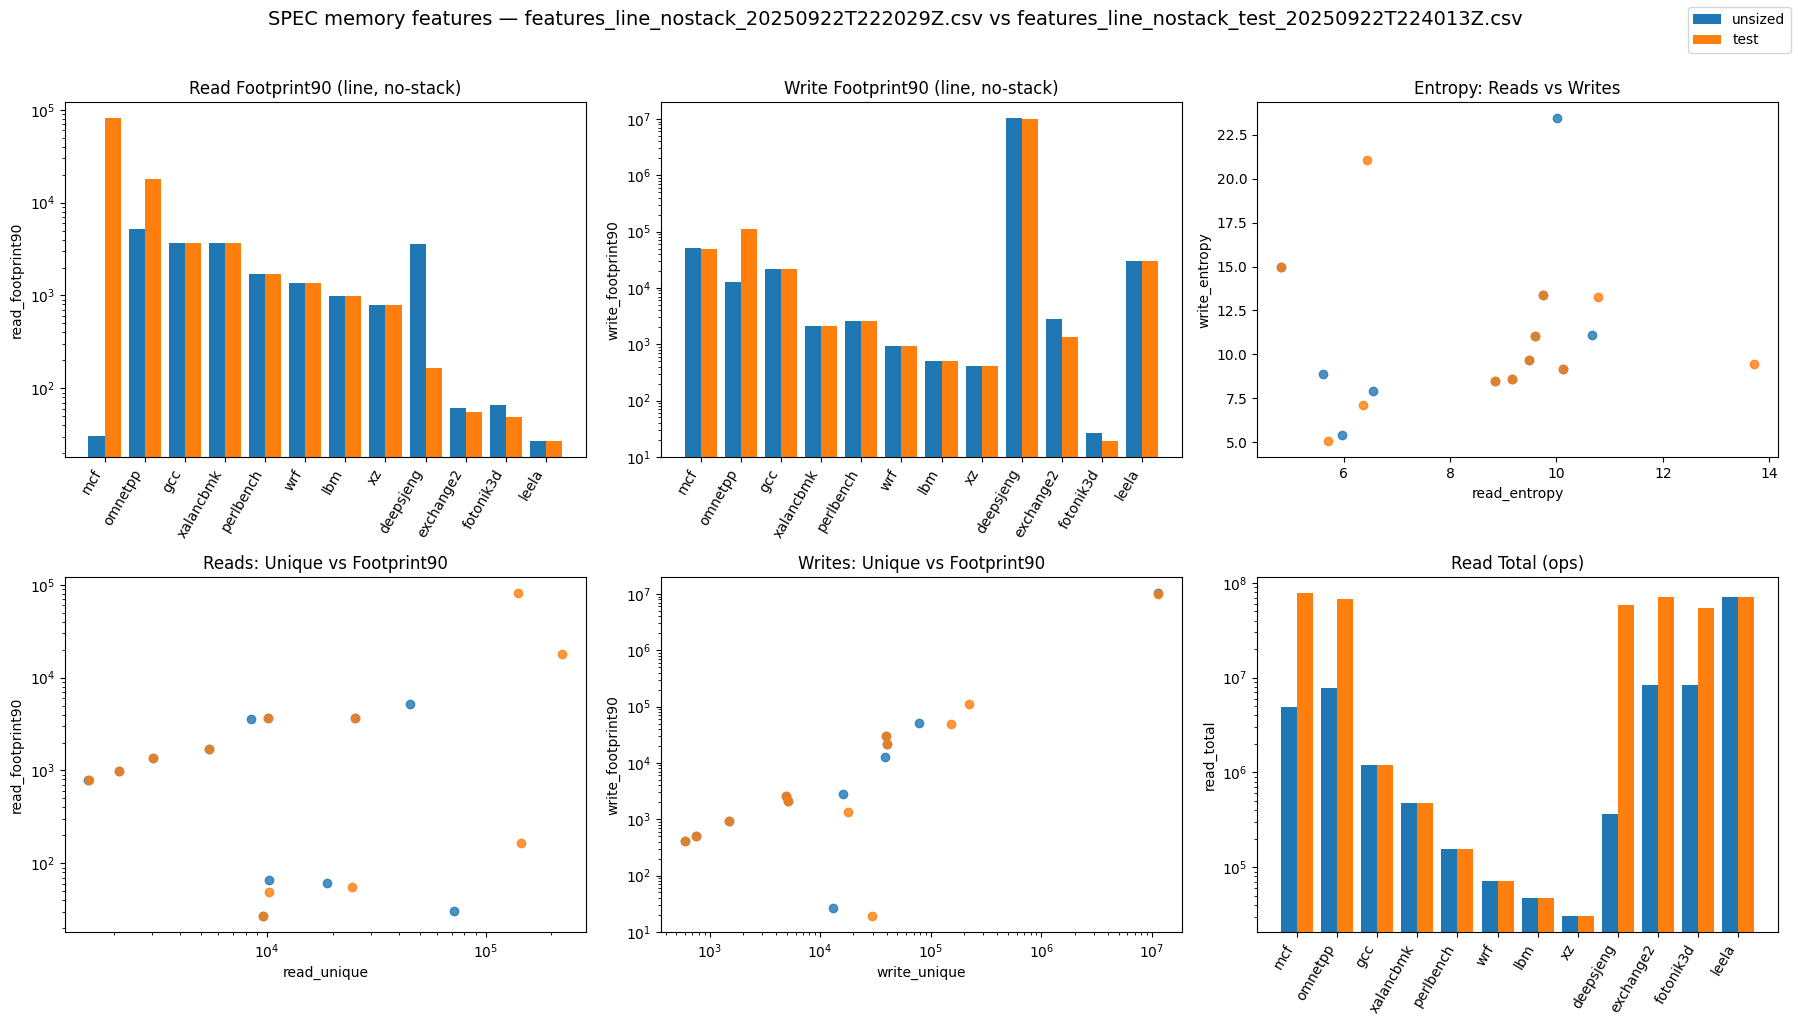

In [9]:
# ONE CELL: 2x3 comparison grid (single figure), uses your two CSVs

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Inline display in Jupyter
try:
    from IPython import get_ipython
    ip = get_ipython()
    if ip: ip.run_line_magic("matplotlib", "inline")
except Exception:
    pass

CSV_1 = "/home/skataoka26/COSC_498/miniMXE/results_trace/features_line_nostack_20250922T222029Z.csv"        # (unsized / older)
CSV_2 = "/home/skataoka26/COSC_498/miniMXE/results_trace/features_line_nostack_test_20250922T224013Z.csv"  # (test)

def infer_label(path: str) -> str:
    n = Path(path).name.lower()
    if "_train_" in n: return "train"
    if "_test_" in n: return "test"
    return "unsized"

def load_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    numcols = ["M","read_total","read_unique","read_entropy","read_local_entropy","read_footprint90",
               "write_total","write_unique","write_entropy","write_local_entropy","write_footprint90"]
    for c in numcols:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    df["label"] = infer_label(path)
    df["source"] = Path(path).name
    return df

def short_name(fullname: str) -> str:
    try:
        return fullname.split(".", 1)[1].split("_", 1)[0]
    except Exception:
        return fullname

df1 = load_csv(CSV_1)
df2 = load_csv(CSV_2)
lab1, lab2 = df1["label"].iloc[0], df2["label"].iloc[0]

# Join on benchmark name so bars align
m = df1.merge(df2, on="name", suffixes=(f" ({lab1})", f" ({lab2})"))
if m.empty:
    raise SystemExit("No overlapping benchmarks between the two CSVs.")

# Sort order: by test (or second) read_footprint90 descending for readability
m = m.sort_values(f"read_footprint90 ({lab2})", ascending=False).reset_index(drop=True)

# Helper to draw side-by-side bars on a given axes
def bars_compare(ax, dfm, col, title, logy=False):
    a, b = f"{col} ({lab1})", f"{col} ({lab2})"
    x = range(len(dfm))
    w = 0.4
    ax.bar([i - w/2 for i in x], dfm[a], width=w, label=lab1)
    ax.bar([i + w/2 for i in x], dfm[b], width=w, label=lab2)
    if logy: ax.set_yscale("log")
    ax.set_xticks(list(x))
    ax.set_xticklabels([short_name(n) for n in dfm["name"]], rotation=60, ha="right")
    ax.set_title(title)
    ax.set_ylabel(col)

# Helper to draw overlaid scatters on a given axes
def scatter_compare(ax, d1, d2, xcol, ycol, title, logx=False, logy=False):
    ax.scatter(d1[xcol], d1[ycol], alpha=0.8, label=lab1)
    ax.scatter(d2[xcol], d2[ycol], alpha=0.8, label=lab2)
    if logx: ax.set_xscale("log")
    if logy: ax.set_yscale("log")
    ax.set_xlabel(xcol); ax.set_ylabel(ycol); ax.set_title(title)

# Build single figure with 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# 1) Read Footprint90 (bars, log scale)
bars_compare(axs[0,0], m, "read_footprint90", "Read Footprint90 (line, no-stack)", logy=True)

# 2) Write Footprint90 (bars, log scale)
bars_compare(axs[0,1], m, "write_footprint90", "Write Footprint90 (line, no-stack)", logy=True)

# 3) Entropy scatter (reads vs writes)
# Pull aligned rows for each label
cols1 = [c for c in m.columns if c.endswith(f"({lab1})")]
cols2 = [c for c in m.columns if c.endswith(f"({lab2})")]
d1 = m[["name"] + cols1].copy()
d2 = m[["name"] + cols2].copy()
# rename back to base names for plotting
d1.columns = [c.split(" (")[0] for c in d1.columns]
d2.columns = [c.split(" (")[0] for c in d2.columns]
scatter_compare(axs[0,2], d1, d2, "read_entropy", "write_entropy", "Entropy: Reads vs Writes")

# 4) Read spread vs hotset (log-log)
scatter_compare(axs[1,0], d1, d2, "read_unique", "read_footprint90",
                "Reads: Unique vs Footprint90", logx=True, logy=True)

# 5) Write spread vs hotset (log-log)
scatter_compare(axs[1,1], d1, d2, "write_unique", "write_footprint90",
                "Writes: Unique vs Footprint90", logx=True, logy=True)

# 6) Read vs Write totals (bars, log scale) — quick workload scale view
bars_compare(axs[1,2], m, "read_total", "Read Total (ops)", logy=True)
# (If you prefer write_total here, swap the col name above)

# Shared legend at top-right
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

fig.suptitle(f"SPEC memory features — {Path(CSV_1).name} vs {Path(CSV_2).name}", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


DR rows: 2868
DR final-like rows: 12
      benchmark    scope  footprint_bytes   H_line   H_page  H_stride  reuse_rate  avg_stride  avg_line_stride  p_stride_le_64  p50_strideB  p90_strideB  p99_strideB  p50_strideL  p90_strideL  p99_strideL
500_perlbench_r interval          2578496 9.699631 5.775959 10.902174    0.991942   3453188.9          53955.9        0.393532       197780      8388608      8388608         3090       131072       131072
      502_gcc_r interval          2582784 9.714732 5.754346 10.904224    0.991929   3473526.7          54273.7        0.392491       248328      8388608      8388608         3880       131072       131072
      505_mcf_r interval          2286080 9.851534 5.896305 10.922537    0.992856   3350433.0          52350.3        0.404834        92136      8388608      8388608         1439       131072       131072
  520_omnetpp_r interval          2581888 9.696906 5.756839 10.903765    0.991932   3472407.8          54256.2        0.392567       242456    

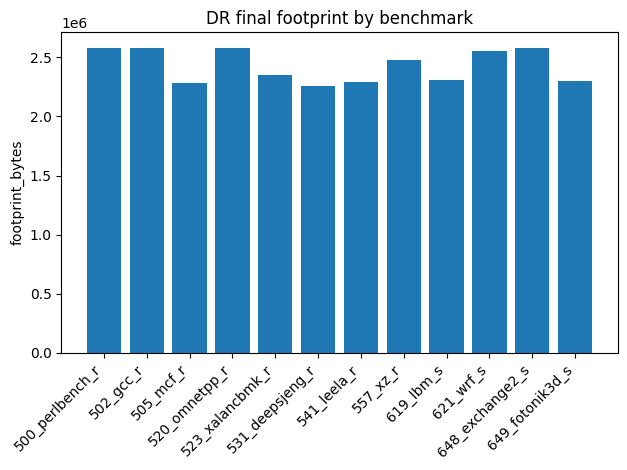

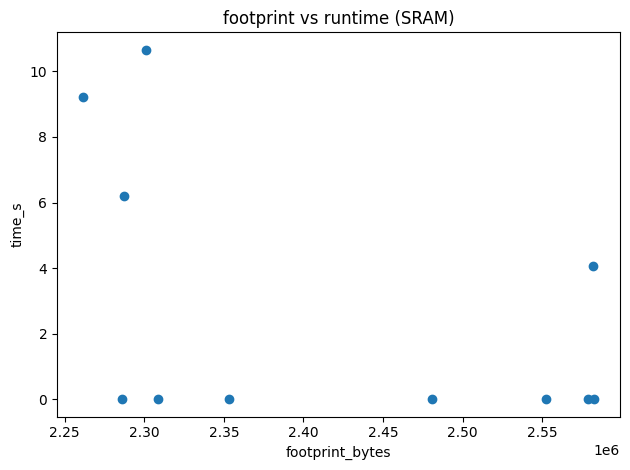

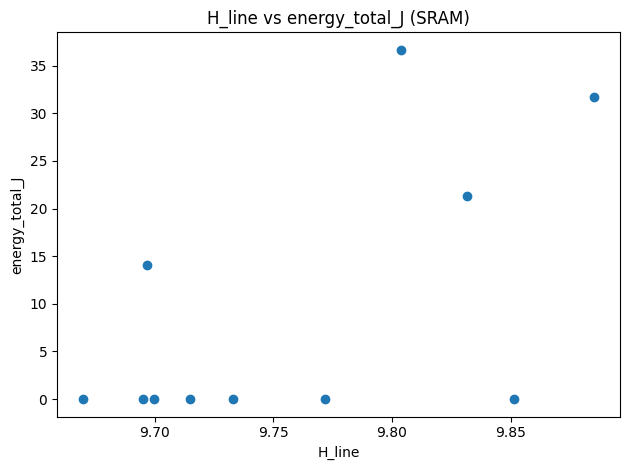

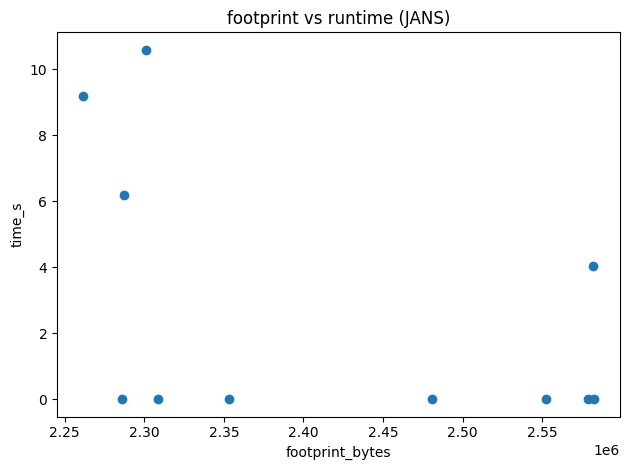

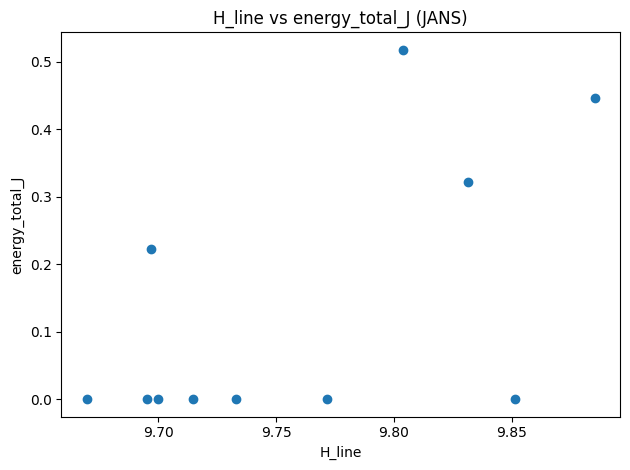

In [13]:
import os, re, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

log_dir = "/home/skataoka26/COSC_498/miniMXE/results_trace/logs"
sniper_root = "/home/skataoka26/COSC_498/miniMXE/results/test_all_spec_benchmarks_iso8m_20250921T153104Z"

rows = []
for f in sorted(glob.glob(os.path.join(log_dir, "*_instr.rwstats.log"))):
    m = re.search(r"\d{8}T\d{6}Z_(.+?)_instr\.rwstats\.log$", os.path.basename(f))
    if not m:
        continue
    bench = m.group(1)
    with open(f, "r", encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            line = line.strip()
            if not line.startswith("scope="):
                continue
            parts = line.split(",")
            rec = {"benchmark": bench}
            for p in parts:
                if "=" in p:
                    k, v = p.split("=", 1)
                    k = k.strip(); v = v.strip()
                    try:
                        if v.lower() == "nan":
                            rec[k] = np.nan
                        else:
                            rec[k] = float(v) if (("." in v) or ("e" in v.lower())) else int(v)
                    except:
                        rec[k] = v
            rows.append(rec)

dr_df = pd.DataFrame(rows)
if not dr_df.empty:
    dr_df["scope"] = dr_df["scope"].astype(str)
    dr_df["is_final"] = dr_df["scope"].str.lower().eq("final")
    dr_df["is_interval"] = dr_df["scope"].str.lower().eq("interval")
    dr_df["interval_idx"] = dr_df.groupby("benchmark")["is_interval"].cumsum().where(dr_df["is_interval"], np.nan)
    dr_df = dr_df.sort_values(["benchmark","interval_idx"], kind="mergesort")

print("DR rows:", len(dr_df))

dr_final = dr_df[dr_df["is_final"]].copy()
if dr_final.empty and not dr_df.empty:
    dr_final = dr_df.groupby("benchmark", as_index=False).tail(1).copy()

dr_feat_cols = ["footprint_bytes","H_line","H_page","H_stride","reuse_rate","avg_stride","avg_line_stride","p_stride_le_64","p50_strideB","p90_strideB","p99_strideB","p50_strideL","p90_strideL","p99_strideL"]
dr_final = dr_final[["benchmark","scope"] + [c for c in dr_feat_cols if c in dr_final.columns]].copy()

out_dirs = sorted(glob.glob(os.path.join(sniper_root, "output_*")))
sn_list = []
for od in out_dirs:
    bench = os.path.basename(od).replace("output_","")
    eb = os.path.join(od, "energy_bounds.csv")
    sm = os.path.join(od, "summary.csv")
    if not (os.path.isfile(eb) and os.path.isfile(sm)):
        continue
    try:
        e = pd.read_csv(eb)
        s = pd.read_csv(sm)
    except:
        continue
    e["benchmark"] = bench
    s["benchmark"] = bench
    if "config" in e.columns: e["config"] = e["config"].astype(str).str.upper()
    if "config" in s.columns: s["config"] = s["config"].astype(str).str.upper()
    if "time_ns" in s.columns:
        s["time_s_from_summary"] = s["time_ns"].astype(float) / 1e9
    if "dyn_exact_nJ" in e.columns:
        e["dyn_exact_J"] = e["dyn_exact_nJ"].astype(float) / 1e9
    else:
        if "dyn_exact_J" not in e.columns:
            e["dyn_exact_J"] = np.nan
    if "energy_exact_J" in e.columns:
        e["energy_total_J"] = e["energy_exact_J"].astype(float)
    else:
        e["energy_total_J"] = e.get("dyn_exact_J", pd.Series(np.nan, index=e.index)).astype(float) + e.get("leak_J", pd.Series(np.nan, index=e.index)).astype(float)
    cols_e = ["benchmark","n_m","config","time_s","leak_J","dyn_exact_J","energy_total_J"]
    cols_s = ["benchmark","config","time_ns","ipc","instructions","cycles","time_s_from_summary"]
    e2 = e[[c for c in cols_e if c in e.columns]].copy()
    s2 = s[[c for c in cols_s if c in s.columns]].copy()
    m = pd.merge(e2, s2, on=["benchmark","config"], how="outer")
    m["benchmark"] = bench
    sn_list.append(m)

sniper_df = pd.concat(sn_list, ignore_index=True) if sn_list else pd.DataFrame()
if sniper_df.empty:
    print("No Sniper data found under:", sniper_root)

if not sniper_df.empty:
    sniper_df["config"] = sniper_df["config"].astype(str).str.upper()
    roi_mode = sniper_df["n_m"].dropna().mode()
    roi_pick = int(roi_mode.iloc[0]) if not roi_mode.empty else None
    if roi_pick is not None:
        sniper_df = sniper_df[(sniper_df["n_m"]==roi_pick) | (sniper_df["n_m"].isna())].copy()
    if "time_s_from_summary" in sniper_df.columns:
        sniper_df["time_s"] = sniper_df["time_s_from_summary"].where(sniper_df["time_s_from_summary"].notna(), sniper_df.get("time_s"))
    sniper_df["time_s"] = pd.to_numeric(sniper_df.get("time_s"), errors="coerce")
    sniper_df["instructions"] = pd.to_numeric(sniper_df.get("instructions"), errors="coerce")
    sniper_df["cycles"] = pd.to_numeric(sniper_df.get("cycles"), errors="coerce")
    sniper_df["ipc"] = pd.to_numeric(sniper_df.get("ipc"), errors="coerce")
    sniper_df["energy_total_J"] = pd.to_numeric(sniper_df.get("energy_total_J"), errors="coerce")
    sniper_df["dyn_exact_J"] = pd.to_numeric(sniper_df.get("dyn_exact_J"), errors="coerce")
    sniper_df["leak_J"] = pd.to_numeric(sniper_df.get("leak_J"), errors="coerce")
    sniper_df["time_per_instr"] = sniper_df["time_s"] / sniper_df["instructions"]
    sniper_df["energy_per_instr"] = sniper_df["energy_total_J"] / sniper_df["instructions"]

print("DR final-like rows:", len(dr_final))
print(dr_final.sort_values("benchmark").to_string(index=False))

if not sniper_df.empty:
    print("\nSniper rows (filtered):", len(sniper_df))
    print(sniper_df.sort_values(["benchmark","config"]).head(12).to_string(index=False))

def corr_tables_for_config(cfg):
    if sniper_df.empty or dr_final.empty:
        return None, None, None
    sn_cfg = sniper_df[sniper_df["config"]==cfg].copy()
    if sn_cfg.empty:
        return None, None, None
    perf_cols = ["time_s","time_per_instr","energy_total_J","energy_per_instr","dyn_exact_J","leak_J","ipc","instructions","cycles"]
    sn_sel = sn_cfg[["benchmark"] + [c for c in perf_cols if c in sn_cfg.columns]].copy()
    merged = pd.merge(dr_final, sn_sel, on="benchmark", how="inner")
    if merged.empty:
        return None, None, None
    if "time_s" in merged.columns:
        merged = merged[ (merged["time_s"].isna()) | (merged["time_s"] >= 0.01) ].copy()
    feat_cols = [c for c in dr_feat_cols if c in merged.columns]
    const_feats = [c for c in feat_cols if merged[c].nunique(dropna=True) <= 1]
    feat_cols = [c for c in feat_cols if c not in const_feats]
    keep_cols = ["benchmark"] + feat_cols + [c for c in perf_cols if c in merged.columns]
    merged = merged[keep_cols].dropna(axis=1, how="all").copy()
    pear = merged.drop(columns=["benchmark"]).corr(method="pearson")
    spear = merged.drop(columns=["benchmark"]).corr(method="spearman")
    feats_in = [c for c in feat_cols if c in pear.index]
    perfs_in = [c for c in ["time_s","time_per_instr","energy_total_J","energy_per_instr","ipc","instructions","cycles"] if c in pear.columns]
    return merged, pear.loc[feats_in, perfs_in].round(3), spear.loc[feats_in, perfs_in].round(3)

for cfg in ["SRAM","JANS"]:
    merged, pear, spear = corr_tables_for_config(cfg)
    if merged is None:
        print(f"\nNo merged data for config={cfg}")
        continue
    print(f"\nMerged rows for {cfg}:", len(merged))
    print(f"\nPearson correlations ({cfg}):")
    print(pear)
    print(f"\nSpearman correlations ({cfg}):")
    print(spear)

if not dr_final.empty:
    plt.figure()
    fs = dr_final.sort_values("benchmark")
    plt.bar(fs["benchmark"], fs["footprint_bytes"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("footprint_bytes")
    plt.title("DR final footprint by benchmark")
    plt.tight_layout()
    plt.show()

if not sniper_df.empty:
    for cfg in ["SRAM","JANS"]:
        sn_cfg = sniper_df[sniper_df["config"]==cfg]
        if sn_cfg.empty: 
            continue
        sc = pd.merge(dr_final, sn_cfg[["benchmark","time_s","energy_total_J"]], on="benchmark", how="inner")
        if sc.empty: 
            continue
        if "time_s" in sc.columns:
            plt.figure()
            plt.scatter(sc["footprint_bytes"], sc["time_s"])
            plt.xlabel("footprint_bytes")
            plt.ylabel("time_s")
            plt.title(f"footprint vs runtime ({cfg})")
            plt.tight_layout()
            plt.show()
        if "energy_total_J" in sc.columns:
            plt.figure()
            plt.scatter(sc["H_line"], sc["energy_total_J"])
            plt.xlabel("H_line")
            plt.ylabel("energy_total_J")
            plt.title(f"H_line vs energy_total_J ({cfg})")
            plt.tight_layout()
            plt.show()


In [5]:
sum_csv

'/home/skataoka26/COSC_498/miniMXE/results/test_all_spec_benchmarks_iso8m_20250921T153104Z/summary.csv'